In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
import os
from matplotlib.patches import Rectangle, Arc
from tensorflow.keras.models import load_model

Formations_DataFrame

In [2]:
df_total = pd.read_csv('C:/Users/guill/OneDrive/Escritorio/Actual/Master IA/ProjAp/Models/players_pos_final.csv')

def fecha_a_temporada(fecha):
    if fecha.month >= 8:
        return '{}-{}'.format(fecha.year, str(fecha.year + 1)[-2:])
    else:
        return '{}-{}'.format(str(fecha.year - 1)[-2:], str(fecha.year)[-2:])
    
df_total['date'] = pd.to_datetime(df_total['date'])
df_total.insert(1, 'season', df_total['date'].apply(fecha_a_temporada))
df_total.drop('date', axis=1, inplace=True)
df_total['season'] = df_total['season'].str.replace('-', '/')
df_total['season'] = df_total['season'].str.replace('(\d{2})/(\d{2})', '20\\1/20\\2')
df_total.loc[df_total['season'].str.len() > 9, 'season'] = df_total.loc[df_total['season'].str.len() > 9, 'season'].str.slice(2)

df_total

<ipython-input-2-3a6c142afaf5>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_total['season'] = df_total['season'].str.replace('(\d{2})/(\d{2})', '20\\1/20\\2')


,Name,season,player_api_id,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,GK,LB,LM,LW,LWB,RB,RM,RW,RWB,ST
0,A. Cresswell,2015/2016,155782,170.18,146,74.0,76.0,0,2,1,...,0,1,0,0,0,0,0,0,0,0
1,A. Cresswell,2015/2016,155782,170.18,146,74.0,76.0,0,2,1,...,0,1,0,0,0,0,0,0,0,0
2,A. Cresswell,2015/2016,155782,170.18,146,73.0,75.0,0,2,1,...,0,1,0,0,0,0,0,0,0,0
3,A. Cresswell,2015/2016,155782,170.18,146,73.0,75.0,0,2,1,...,0,1,0,0,0,0,0,0,0,0
4,A. Cresswell,2015/2016,155782,170.18,146,73.0,75.0,0,2,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176156,Z. Misimovic,2009/2010,39902,180.34,176,83.0,85.0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
176157,Z. Misimovic,2008/2009,39902,180.34,176,78.0,80.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
176158,Z. Misimovic,2008/2009,39902,180.34,176,77.0,80.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
176159,Z. Misimovic,2007/2008,39902,180.34,176,78.0,81.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
conn = sqlite3.connect('C:/Users/guill/OneDrive/Escritorio/Actual/Master IA/ProjAp/database.sqlite')
df_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
df_tables

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


In [4]:
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
print(len(df_match))
df_match.tail(4)

25979


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,25979,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992095,10192,9931,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
for i in df_match.columns:
    print(i)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

In [6]:
df_match['goal'][0:10000]

0                                                    None
1                                                    None
2                                                    None
3                                                    None
4                                                    None
                              ...                        
9995    <goal><value><comment>n</comment><stats><goals...
9996    <goal><value><comment>n</comment><stats><goals...
9997    <goal><value><comment>n</comment><stats><goals...
9998                                             <goal />
9999    <goal><value><comment>n</comment><stats><goals...
Name: goal, Length: 10000, dtype: object

In [7]:
df_match

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print('Antes del filtrado:',len(df_match))
# seleccionar las columnas de interés
cols = ['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5',
        'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10',
        'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4',
        'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9',
        'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
        'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8',
        'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2',
        'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
        'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11','home_player_1', 
        'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 
        'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 
        'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 
        'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']

# eliminar las filas con valores nulos en las columnas seleccionadas
df_match = df_match.dropna(subset=cols)
print('Despues del filtrado:',len(df_match))
df_match.sample(2)

Antes del filtrado: 25979
Despues del filtrado: 21361


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
2749,2750,1729,1729,2010/2011,33,2011-04-17 00:00:00,840175,9825,8650,1,...,5.0,1.7,3.8,5.25,1.7,3.75,4.5,1.75,3.5,4.5
25534,25535,24558,24558,2013/2014,27,2014-03-30 00:00:00,1471909,10243,7730,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### EDA - Formaciones:

In [9]:
def PlotMatchForm(id_match,equipo):
    
    if equipo == 'visit':
        home_x = ['away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5',           
                  'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11']
        home_y = ['away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5',           
                  'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11']
    if equipo == 'local':
        home_x = ['home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5',           
                  'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11']
        home_y = ['home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5',           
                  'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11']

    df_match_act = df_match[df_match['match_api_id'] == id_match]
    df_match_act_home_x = df_match_act[home_x]
    df_match_act_home_y = df_match_act[home_y]
    
    api_id_home = df_match_act['home_team_api_id'].values[0]
    api_id_away = df_match_act['away_team_api_id'].values[0]
    local = df_team[df_team['team_api_id']==api_id_home]['team_long_name'].values[0]
    visit = df_team[df_team['team_api_id']==api_id_away]['team_long_name'].values[0]
    seson = df_match_act['season'].values[0]
    home_goal = df_match_act['home_team_goal'].values[0]
    away_goal = df_match_act['away_team_goal'].values[0]

    # Crear una figura y un eje
    fig, ax = plt.subplots(figsize=(5.25*4, 3.4*4))

    # Dibujar el campo de fútbol
    ax.fill_between([0,12], [0, 0], [12, 12], color='green')
    ax.add_patch(Rectangle((3,-1.1), 4, 3, fill=False, linewidth=2, color='white'))
    ax.add_patch(Arc((5, 12), 5, 5, theta1=1, theta2=0, linewidth=2, color='white'))
    ax.add_patch(Rectangle((4.4,-1.1), 1.25, 1, fill=False, linewidth=2, color='white'))
    ax.add_patch(Arc((5,1.9), 2, 3, theta1=0, theta2=180, linewidth=2, color='white'))
    
    if equipo == 'local':
        ax.set_title('\n Formacion del ' +str(local)+ '\n' +
                     str(local) + ' VS. ' + str(visit) +' en ' +str(seson)+  '\n' +
                     'Resultado: ' +str(home_goal) + ' - ' + str(away_goal), 
                     fontsize=30)
    if equipo == 'visit':
        ax.set_title('\n Formacion del ' +str(visit)+ '\n' +
                     str(local) + ' VS. ' + str(visit) +' en ' +str(seson)+  '\n' +
                     'Resultado: ' +str(home_goal) + ' - ' + str(away_goal), 
                     fontsize=30)

    # Dibujar las posiciones de los jugadores
    ax.scatter(df_match_act_home_x, df_match_act_home_y, color='black', s=400)

    # Configurar los límites del eje y etiquetas
    ax.set_xlim([1, 9])
    ax.set_ylim([0, 12])
    ax.set_xticks(range(1, 9))
    ax.set_yticks(range(0, 13))
    ax.set_xticklabels([str(x) for x in range(1, 9)])
    ax.set_yticklabels([str(y) for y in range(0, 13)])


    # Mostrar el mapa
    plt.show()

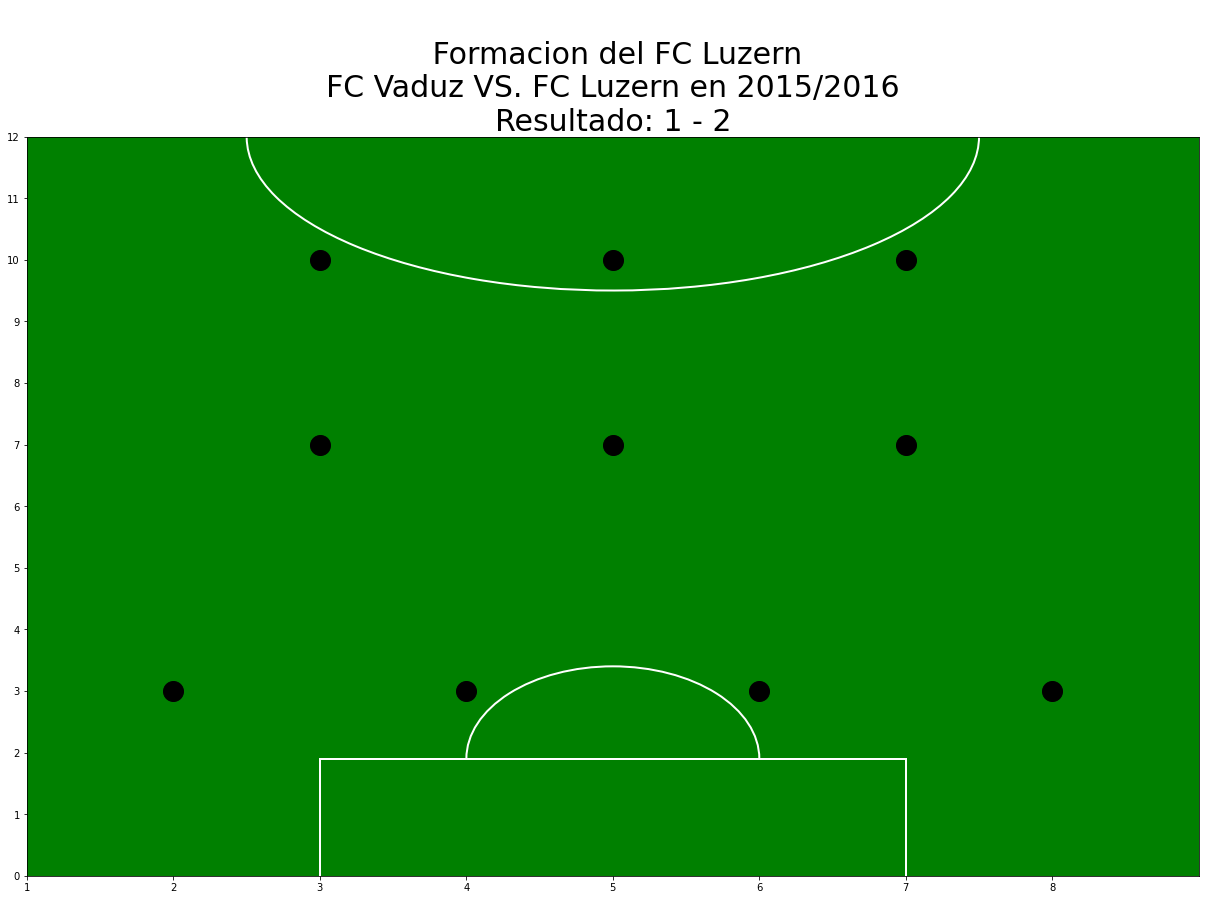

In [10]:
PlotMatchForm(1992092,'visit')

In [11]:
df_match.tail()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
25972,25973,24558,24558,2015/2016,8,2015-09-13 00:00:00,1992089,10243,10191,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,25979,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992095,10192,9931,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


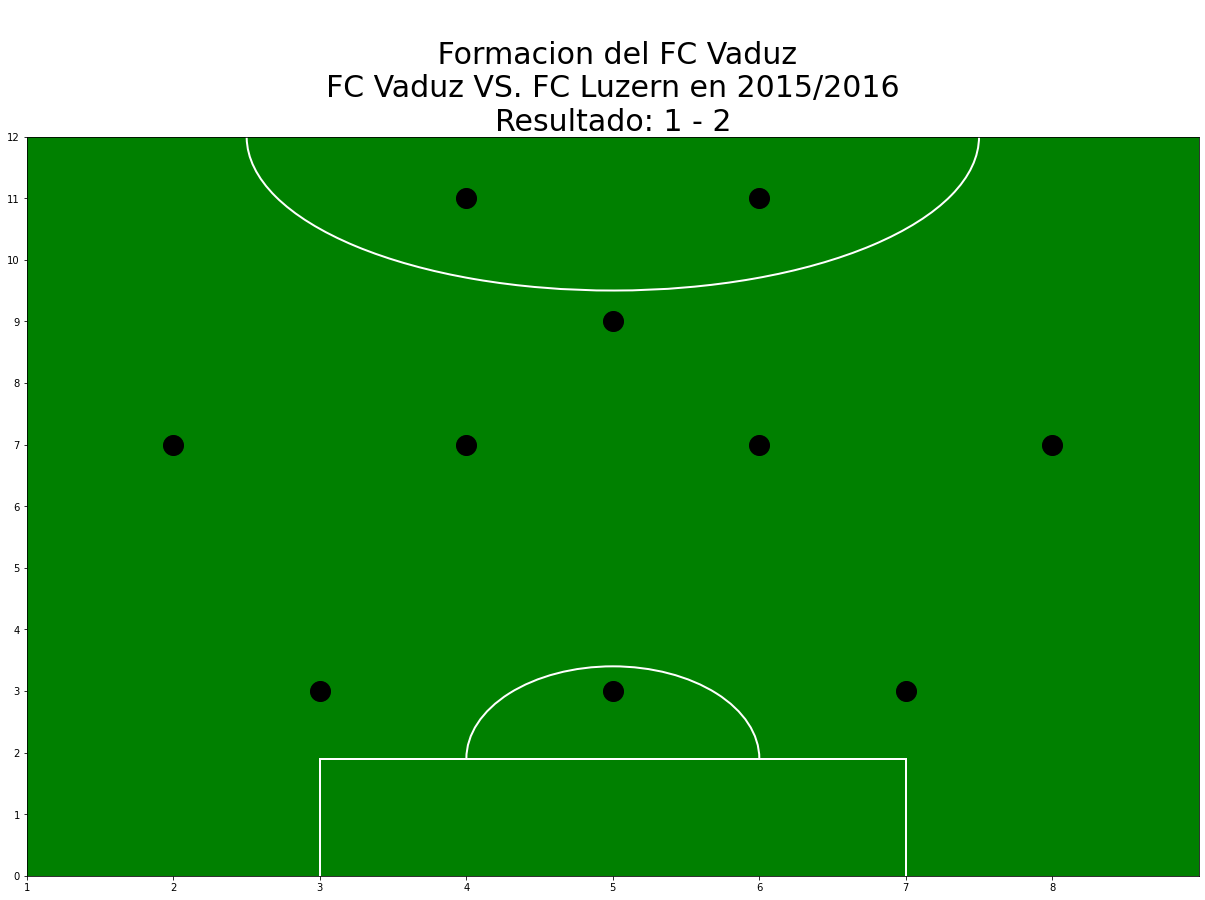

In [12]:
PlotMatchForm(1992092,'local')

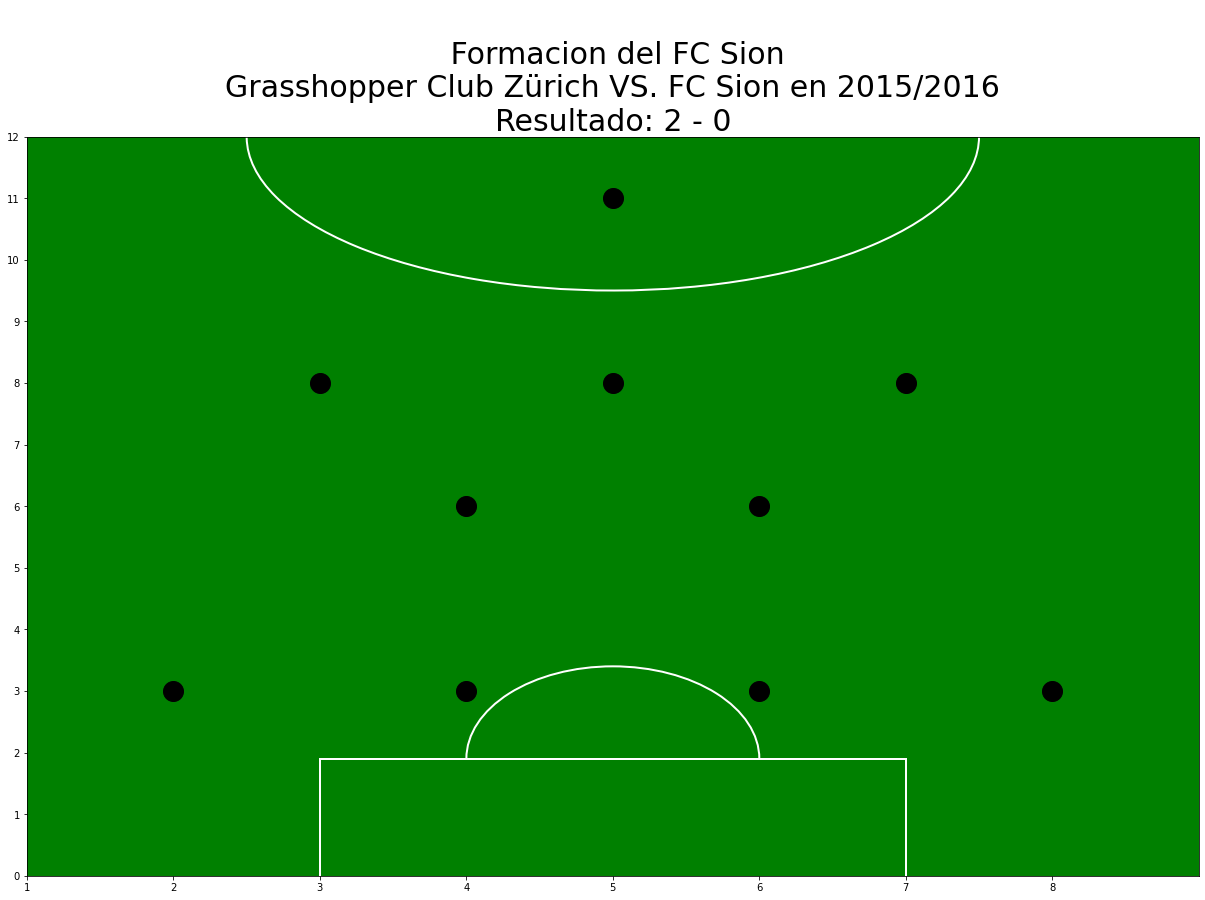

In [13]:
PlotMatchForm(1992093,'visit')

In [14]:
print('Barça Id:',df_team[df_team['team_long_name'] == 'FC Barcelona']['team_api_id'].values[0])
print('Madrid Id:',df_team[df_team['team_long_name'] == 'Real Madrid CF']['team_api_id'].values[0])

Barça Id: 8634
Madrid Id: 8633


In [15]:
barsa_madrid = df_match[((df_match['home_team_api_id'] == 8634) | (df_match['away_team_api_id'] == 8634)) & 
         ((df_match['home_team_api_id'] == 8633) | (df_match['away_team_api_id'] == 8633))]
print('Partidos entre Barça i Madrid:', len(barsa_madrid))
barsa_madrid[barsa_madrid['home_team_goal']==5]

Partidos entre Barça i Madrid: 16


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
22320,22321,21518,21518,2010/2011,13,2010-11-29 00:00:00,875704,8634,8633,5,...,3.5,2.1,3.6,3.5,2.1,3.5,3.3,2.1,3.6,3.3


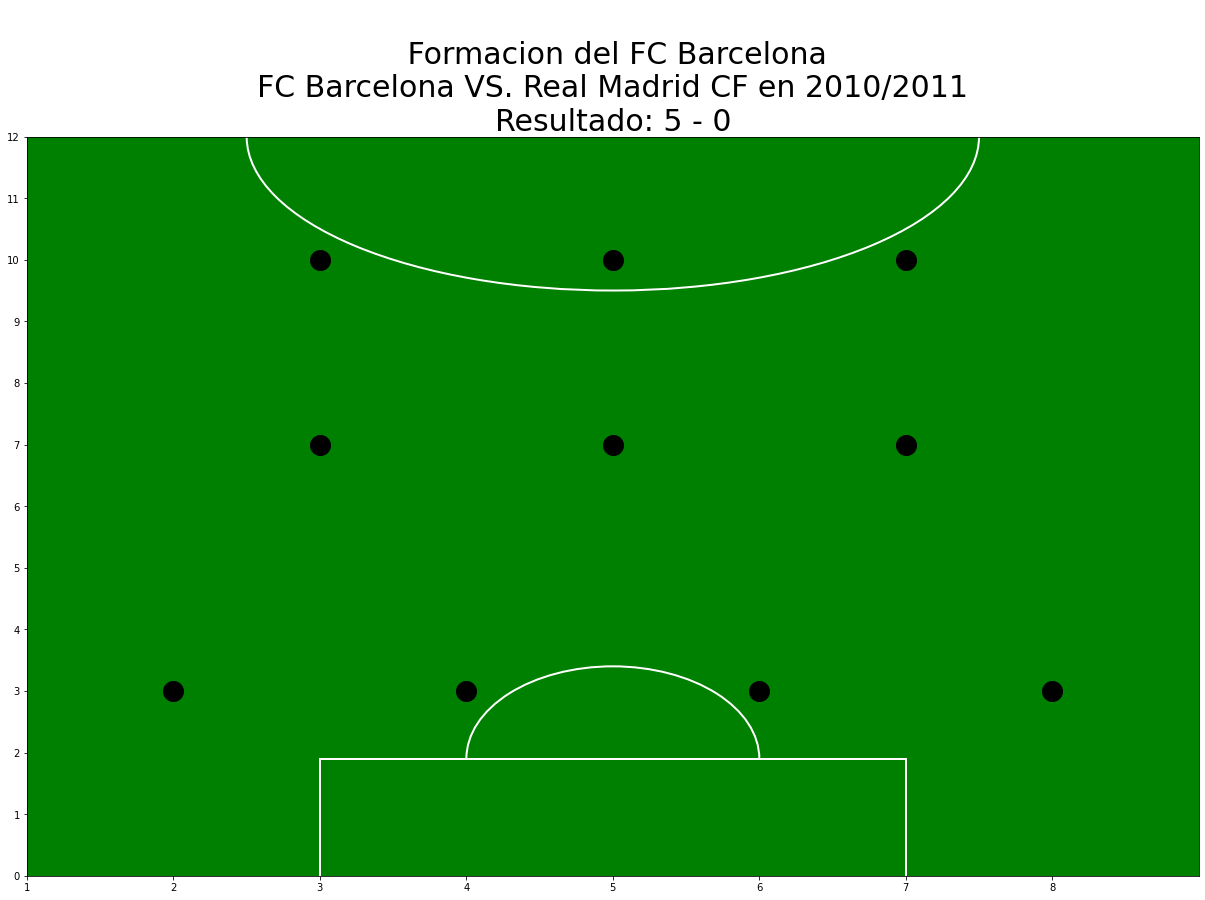

In [16]:
PlotMatchForm(875704,'local')

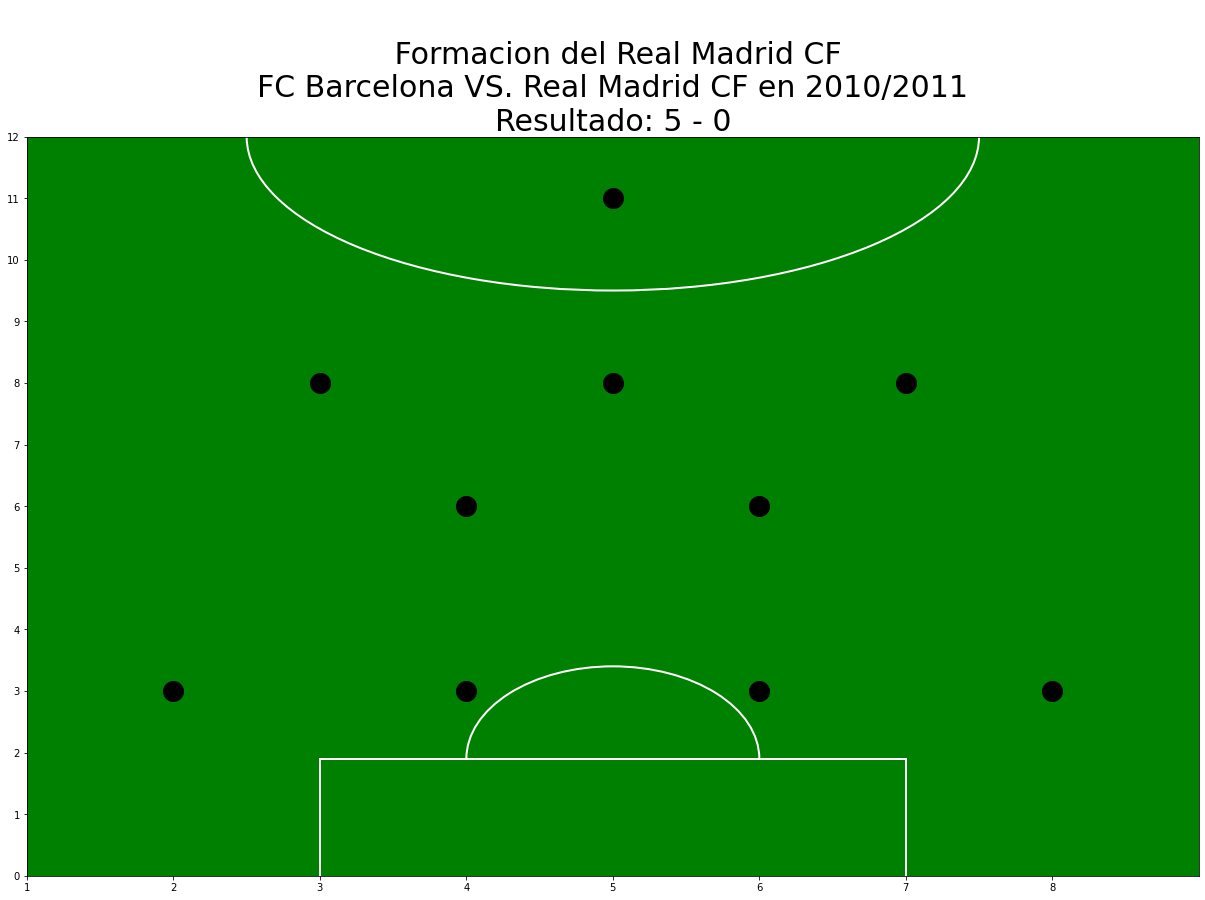

In [17]:
PlotMatchForm(875704,'visit')

### Crear formaciones de los equipos:

In [18]:
def CrearFormaciones(df):
    home_formation = str((df.loc['home_player_Y2':'home_player_Y11'] < 4).sum()) + '-' + str(((df.loc['home_player_Y2':'home_player_Y11'] >= 4) & (df.loc['home_player_Y2':'home_player_Y11'] < 9)).sum()) + '-' + str((df.loc['home_player_Y2':'home_player_Y11'] >= 9).sum())
    away_formation = str((df.loc['away_player_Y2':'away_player_Y11'] < 4).sum()) + '-' + str(((df.loc['away_player_Y2':'away_player_Y11'] >= 4) & (df.loc['away_player_Y2':'away_player_Y11'] < 9)).sum()) + '-' + str((df.loc['away_player_Y2':'away_player_Y11'] >= 9).sum())
    df['home_formation'] = home_formation
    df['away_formation'] = away_formation
    return df

df_formaciones = df_match.apply(CrearFormaciones, axis=1)

In [19]:
cols = ['league_id', 'season', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 
                'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2', 'home_player_3', 
                'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 
                'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 
                'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 
                'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11','home_formation',
                'away_formation']
df_formaciones = df_formaciones.loc[:,cols]
df_formaciones

,league_id,season,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,...,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,home_formation,away_formation
145,1,2008/2009,493017,8203,9987,2,1,38327.0,67950.0,67958.0,...,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0,4-4-2,4-4-2
153,1,2008/2009,493025,9984,8342,1,3,36835.0,37047.0,37021.0,...,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0,4-4-2,4-4-2
155,1,2008/2009,493027,8635,10000,2,0,34480.0,38388.0,26458.0,...,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0,4-4-2,4-4-2
162,1,2008/2009,493034,8203,8635,2,1,38327.0,67950.0,67958.0,...,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0,4-4-2,4-4-2
168,1,2008/2009,493040,10000,9999,0,0,37900.0,37886.0,37100.0,...,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0,4-4-2,4-4-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,24558,2015/2016,1992089,10243,10191,3,3,274776.0,451982.0,34268.0,...,67304.0,67389.0,133126.0,186524.0,93223.0,121115.0,25809.0,289732.0,4-4-2,4-5-1
25974,24558,2015/2016,1992091,10190,10191,1,0,42231.0,678384.0,95220.0,...,67304.0,158253.0,133126.0,186524.0,93223.0,121115.0,232110.0,289732.0,4-5-1,4-5-1
25975,24558,2015/2016,1992092,9824,10199,1,2,33272.0,41621.0,25813.0,...,178119.0,27232.0,570830.0,260708.0,201704.0,36382.0,34082.0,95257.0,3-4-3,4-3-3
25976,24558,2015/2016,1992093,9956,10179,2,0,157856.0,274779.0,177689.0,...,32597.0,114794.0,188114.0,25840.0,482200.0,95230.0,451335.0,275122.0,4-5-1,4-5-1


### Formaciones Plot:

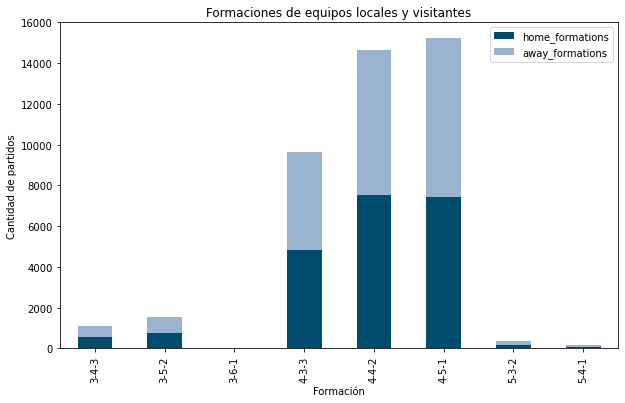

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener conteos de las formaciones del equipo local y visitante
home_formations = df_formaciones['home_formation'].value_counts()
away_formations = df_formaciones['away_formation'].value_counts()

# Crear DataFrame con ambos conteos
formations_df = pd.DataFrame({'home_formations': home_formations, 'away_formations': away_formations})

# Crear gráfico de barras apiladas
ax = formations_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#004c6d', '#9ab3ce'])

# Configurar títulos y etiquetas de los ejes
ax.set_title('Formaciones de equipos locales y visitantes')
ax.set_xlabel('Formación')
ax.set_ylabel('Cantidad de partidos')

# Mostrar el gráfico
plt.show()

In [21]:
formations_df

,home_formations,away_formations
3-4-3,540,541
3-5-2,756,788
3-6-1,7,10
4-3-3,4845,4817
4-4-2,7538,7114
4-5-1,7451,7795
5-3-2,166,175
5-4-1,58,121


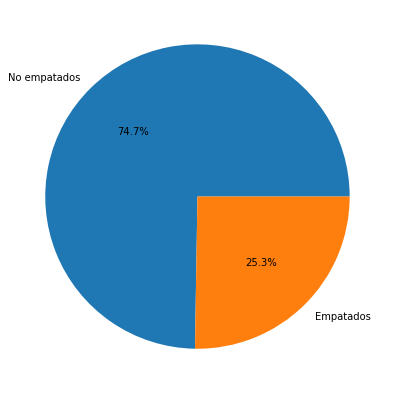

In [22]:
# calcular el porcentaje de partidos empatados
empates = df_formaciones[df_formaciones["home_team_goal"] == df_formaciones["away_team_goal"]].reset_index(drop=True)
porcentaje_empates = len(empates) / len(df_formaciones) * 100

# crear el gráfico
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie([len(df_formaciones) - len(empates), len(empates)], labels=["No empatados", "Empatados"], autopct="%1.1f%%")

# mostrar el gráfico
plt.show()

### Rediseñando el dataframe:

In [23]:
df_formaciones.to_csv('C:/Users/guill/OneDrive/Escritorio/Actual/Master IA/ProjAp/Models/df_formaciones.csv', index=False)

In [24]:
df_wining_form = df_formaciones.copy()
df_wining_form = df_wining_form[df_wining_form["home_team_goal"] != df_wining_form["away_team_goal"]]


def winner(row):
    if row["home_team_goal"] > row["away_team_goal"]:
        return "Local"
    elif row["home_team_goal"] < row["away_team_goal"]:
        return "Visitante"
    
def FormacionGanadora(row):
    # Comparamos los goles de ambos equipos
    if row['home_team_goal'] > row['away_team_goal']:
        # Si el equipo local gana, asignamos su formación a la nueva columna
        return row['home_formation']
    elif row['away_team_goal'] > row['home_team_goal']:
        # Si el equipo visitante gana, asignamos su formación a la nueva columna
        return row['away_formation']
    else:
        # Si hay un empate, asignamos un valor nulo
        return None

df_wining_form["Winner"] = df_wining_form.apply(winner, axis=1)
df_wining_form['winning_team_formation'] = df_wining_form.apply(FormacionGanadora, axis=1)
df_wining_form = df_wining_form.drop(['home_team_goal','away_team_goal','match_api_id','league_id',
                                     'home_formation', 'away_formation'],axis=1)
df_wining_form.sample(5)

,season,home_team_api_id,away_team_api_id,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,...,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,Winner,winning_team_formation
13767,2009/2010,9791,9761,26663.0,110116.0,37965.0,26470.0,26661.0,26664.0,45944.0,...,5693.0,26621.0,38103.0,46067.0,37789.0,42707.0,30921.0,25640.0,Local,4-4-2
20495,2011/2012,9927,9860,37780.0,181227.0,4939.0,156019.0,35502.0,46015.0,37294.0,...,37307.0,32891.0,112297.0,32681.0,105526.0,23317.0,24449.0,32593.0,Local,4-4-2
12357,2013/2014,8543,8533,39599.0,39562.0,27660.0,26171.0,185925.0,11685.0,39334.0,...,26223.0,25519.0,39487.0,15732.0,42651.0,42482.0,109121.0,38920.0,Local,4-4-2
13633,2009/2010,8614,8640,22822.0,45502.0,26614.0,164246.0,128802.0,112471.0,26638.0,...,34479.0,37194.0,26434.0,5703.0,38913.0,36789.0,39139.0,72374.0,Visitante,4-3-3
1402,2014/2015,9991,8342,181069.0,49451.0,91503.0,186621.0,67958.0,40521.0,25751.0,...,445873.0,178293.0,109061.0,26440.0,277771.0,113868.0,14557.0,37069.0,Local,4-3-3


In [25]:
# Crea una lista de diccionarios que contendrá los datos del nuevo dataframe
data = []

df = df_wining_form.copy()
# Itera sobre las filas del dataframe original
for index, row in df.iterrows():
    # Crea dos nuevos diccionarios que representan la información de los jugadores ganadores y perdedores
    if row['Winner'] == 'Local':
        winner_dict = {'winner_player{}'.format(i+1): row['home_player_{}'.format(i+1)] for i in range(11)}
        loser_dict = {'loser_player{}'.format(i+1): row['away_player_{}'.format(i+1)] for i in range(11)}
    else:
        winner_dict = {'winner_player{}'.format(i+1): row['away_player_{}'.format(i+1)] for i in range(11)}
        loser_dict = {'loser_player{}'.format(i+1): row['home_player_{}'.format(i+1)] for i in range(11)}

    # Agrega los diccionarios de los jugadores ganadores y perdedores a la lista de diccionarios
    data.append({'season': row['season'], 'winning_team_formation': row['winning_team_formation'],**winner_dict, **loser_dict})

# Crea un nuevo dataframe a partir de la lista de diccionarios
new_df = pd.DataFrame(data)

# Renombra las columnas según lo solicitado
column_names = {}
for i in range(1, 12):
    column_names['winner_player{}'.format(i)] = 'winner_player{}'.format(i)
    column_names['loser_player{}'.format(i)] = 'loser_player{}'.format(i)
new_df.rename(columns=column_names, inplace=True)


In [26]:
new_df

,season,winning_team_formation,winner_player1,winner_player2,winner_player3,winner_player4,winner_player5,winner_player6,winner_player7,winner_player8,...,loser_player2,loser_player3,loser_player4,loser_player5,loser_player6,loser_player7,loser_player8,loser_player9,loser_player10,loser_player11
0,2008/2009,4-4-2,38327.0,67950.0,67958.0,67959.0,37112.0,36393.0,148286.0,67898.0,...,38293.0,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0
1,2008/2009,4-4-2,37990.0,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,...,37047.0,37021.0,37051.0,104386.0,32863.0,37957.0,37909.0,38357.0,37065.0,78462.0
2,2008/2009,4-4-2,34480.0,38388.0,26458.0,13423.0,38389.0,30949.0,38393.0,38253.0,...,37886.0,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0
3,2008/2009,4-4-2,38327.0,67950.0,67958.0,38801.0,67898.0,37112.0,67959.0,148286.0,...,38388.0,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0
4,2008/2009,4-4-2,104378.0,38248.0,36841.0,38255.0,104382.0,33662.0,37044.0,32760.0,...,37887.0,37886.0,37903.0,94030.0,37981.0,131531.0,131530.0,130027.0,38231.0,75500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15960,2015/2016,4-4-2,274787.0,492132.0,108451.0,25815.0,94553.0,384376.0,598355.0,320184.0,...,114735.0,25813.0,41621.0,358156.0,114011.0,42237.0,56868.0,209371.0,531309.0,113227.0
15961,2015/2016,4-5-1,42231.0,678384.0,95220.0,638592.0,413155.0,45780.0,171229.0,67333.0,...,563066.0,8800.0,67304.0,158253.0,133126.0,186524.0,93223.0,121115.0,232110.0,289732.0
15962,2015/2016,4-3-3,42276.0,114792.0,150007.0,178119.0,27232.0,570830.0,260708.0,201704.0,...,41621.0,25813.0,257845.0,114735.0,42237.0,113227.0,358156.0,32343.0,531309.0,37257.0
15963,2015/2016,4-5-1,157856.0,274779.0,177689.0,294256.0,42258.0,39979.0,173936.0,147959.0,...,67349.0,202663.0,32597.0,114794.0,188114.0,25840.0,482200.0,95230.0,451335.0,275122.0


In [29]:
df_total.columns

Index(['Name', 'season', 'player_api_id', 'height', 'weight', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LB', 'LM', 'LW',
       'LWB', 'RB', 'RM', 'RW', 'RWB', 'ST'],
      dtype='object')

In [30]:
# merging the two dataframes based on the season and the winning/losing player api
df_matches = new_df.copy()
df_player = df_total.copy()
df_player =  df_player.iloc[:,0:43]

In [31]:
df_player_season_stats = df_player.groupby(['season', 'player_api_id']).mean().reset_index()
df_player_season_stats

,season,player_api_id,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2006/2007,2625,175.26,154.0,63.0,64.0,1.0,2.0,1.0,48.0,...,56.0,46.0,64.0,66.0,63.0,14.0,11.0,67.0,9.0,10.0
1,2006/2007,2752,187.96,174.0,62.0,68.0,1.0,1.0,1.0,36.0,...,52.0,35.0,64.0,60.0,65.0,11.0,6.0,7.0,9.0,15.0
2,2006/2007,2768,180.34,154.0,56.0,60.0,0.0,1.0,1.0,43.0,...,57.0,63.0,60.0,56.0,82.0,9.0,21.0,56.0,21.0,21.0
3,2006/2007,2770,180.34,161.0,73.0,74.0,1.0,1.0,0.0,64.0,...,73.0,45.0,21.0,24.0,25.0,2.0,21.0,83.0,21.0,21.0
4,2006/2007,2796,182.88,170.0,60.0,72.0,1.0,1.0,1.0,13.0,...,27.0,19.0,8.0,13.0,9.0,61.0,60.0,56.0,56.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65280,2015/2016,744907,172.72,137.0,53.0,67.0,0.0,1.0,1.0,43.0,...,52.0,53.0,40.0,49.0,50.0,9.0,14.0,13.0,12.0,9.0
65281,2015/2016,746419,175.26,152.0,59.0,66.0,1.0,2.0,1.0,55.0,...,40.0,43.0,55.0,69.0,62.0,7.0,10.0,7.0,9.0,9.0
65282,2015/2016,748432,187.96,176.0,58.0,68.0,1.0,1.0,1.0,48.0,...,36.0,45.0,63.0,69.0,68.0,8.0,8.0,12.0,12.0,6.0
65283,2015/2016,750435,172.72,150.0,57.0,71.0,1.0,1.0,0.0,35.0,...,58.0,61.0,18.0,19.0,21.0,9.0,10.0,8.0,10.0,11.0


In [32]:
play_val2 = 'winner_player1'

df_merged = pd.merge(df_matches, df_player_season_stats, left_on=['season', 'winner_player1'], right_on=['season', 'player_api_id'], how='left')

play_val = play_val2.replace("_player", "")

df_merged.rename(columns={
    'player_api_id': str(play_val) + '_player_api_id',
    'height': str(play_val) +'_height',
    'weight': str(play_val) +'_weight',
    'overall_rating': str(play_val) +'_overall_rating',
    'potential': str(play_val) +'_potential',
    'preferred_foot': str(play_val) +'_preferred_foot',
    'attacking_work_rate': str(play_val) +'_attacking_work_rate',
    'defensive_work_rate': str(play_val) +'_defensive_work_rate',
    'crossing': str(play_val) +'_crossing',
    'finishing': str(play_val) +'_finishing',
    'heading_accuracy': str(play_val) +'_heading_accuracy',
    'short_passing': str(play_val) +'_short_passing',
    'volleys': str(play_val) +'_volleys',
    'dribbling': str(play_val) +'_dribbling',
    'curve': str(play_val) +'_curve',
    'free_kick_accuracy': str(play_val) +'_free_kick_accuracy',
    'long_passing': str(play_val) +'_long_passing',
    'ball_control': str(play_val) +'_ball_control',
    'acceleration': str(play_val) +'_acceleration',
    'sprint_speed': str(play_val) + '_sprint_speed',
    'agility': str(play_val) +'_agility',
    'reactions': str(play_val) +'_reactions',
    'balance': str(play_val) +'_balance',
    'shot_power': str(play_val) +'_shot_power',
    'jumping': str(play_val) +'_jumping',
    'stamina': str(play_val) +'_stamina',
    'strength': str(play_val) +'_strength',
    'long_shots': str(play_val) +'_long_shots',
    'aggression': str(play_val) +'_aggression',
    'interceptions': str(play_val) +'_interceptions',
    'positioning': str(play_val) +'_positioning',
    'vision': str(play_val) +'_vision',
    'penalties': str(play_val) +'_penalties',
    'marking': str(play_val) +'_marking',
    'standing_tackle': str(play_val) +'_standing_tackle',
    'sliding_tackle': str(play_val) +'_sliding_tackle',
    'gk_diving': str(play_val) +'_gk_diving',
    'gk_handling': str(play_val) +'_gk_handling',
    'gk_kicking': str(play_val) +'_gk_kicking',
    'gk_positioning': str(play_val) +'_gk_positioning',
    'gk_reflexes': str(play_val) +'_gk_reflexes'
}, inplace=True)
df_merged = df_merged.drop([str(play_val) +'_player_api_id',str(play_val2)], axis=1)
df_merged

,season,winning_team_formation,winner_player2,winner_player3,winner_player4,winner_player5,winner_player6,winner_player7,winner_player8,winner_player9,...,winner1_vision,winner1_penalties,winner1_marking,winner1_standing_tackle,winner1_sliding_tackle,winner1_gk_diving,winner1_gk_handling,winner1_gk_kicking,winner1_gk_positioning,winner1_gk_reflexes
0,2008/2009,4-4-2,67950.0,67958.0,67959.0,37112.0,36393.0,148286.0,67898.0,164352.0,...,50.000000,48.0,25.0,25.0,35.0,63.000000,51.000000,46.0,53.000000,68.000000
1,2008/2009,4-4-2,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,...,62.000000,62.0,25.0,25.0,21.0,75.000000,70.000000,69.0,71.000000,76.000000
2,2008/2009,4-4-2,38388.0,26458.0,13423.0,38389.0,30949.0,38393.0,38253.0,38383.0,...,49.000000,44.0,39.0,31.0,12.0,67.000000,67.000000,73.0,65.000000,70.000000
3,2008/2009,4-4-2,67950.0,67958.0,38801.0,67898.0,37112.0,67959.0,148286.0,164352.0,...,50.000000,48.0,25.0,25.0,35.0,63.000000,51.000000,46.0,53.000000,68.000000
4,2008/2009,4-4-2,38248.0,36841.0,38255.0,104382.0,33662.0,37044.0,32760.0,38229.0,...,59.000000,57.0,21.0,21.0,19.0,73.000000,51.000000,60.0,62.000000,72.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15960,2015/2016,4-4-2,492132.0,108451.0,25815.0,94553.0,384376.0,598355.0,320184.0,45174.0,...,65.000000,20.0,11.0,18.0,12.0,74.666667,69.333333,66.0,70.000000,77.666667
15961,2015/2016,4-5-1,678384.0,95220.0,638592.0,413155.0,45780.0,171229.0,67333.0,119839.0,...,11.750000,21.0,14.0,11.0,13.0,67.750000,57.000000,60.0,61.500000,65.500000
15962,2015/2016,4-3-3,114792.0,150007.0,178119.0,27232.0,570830.0,260708.0,201704.0,36382.0,...,51.000000,26.0,13.0,11.0,19.0,68.333333,59.000000,64.0,54.333333,70.000000
15963,2015/2016,4-5-1,274779.0,177689.0,294256.0,42258.0,39979.0,173936.0,147959.0,451983.0,...,21.666667,28.0,14.0,19.0,21.0,68.166667,55.500000,67.0,66.000000,67.833333


In [33]:
def TransfItDf(df_merged, play_val2):
    
    df_merged = pd.merge(df_merged, df_player_season_stats, left_on=['season', str(play_val2)], right_on=['season', 'player_api_id'], how='left')

    play_val = play_val2.replace("_player", "")

    df_merged.rename(columns={
        'player_api_id': str(play_val) + '_player_api_id',
        'height': str(play_val) +'_height',
        'weight': str(play_val) +'_weight',
        'overall_rating': str(play_val) +'_overall_rating',
        'potential': str(play_val) +'_potential',
        'preferred_foot': str(play_val) +'_preferred_foot',
        'attacking_work_rate': str(play_val) +'_attacking_work_rate',
        'defensive_work_rate': str(play_val) +'_defensive_work_rate',
        'crossing': str(play_val) +'_crossing',
        'finishing': str(play_val) +'_finishing',
        'heading_accuracy': str(play_val) +'_heading_accuracy',
        'short_passing': str(play_val) +'_short_passing',
        'volleys': str(play_val) +'_volleys',
        'dribbling': str(play_val) +'_dribbling',
        'curve': str(play_val) +'_curve',
        'free_kick_accuracy': str(play_val) +'_free_kick_accuracy',
        'long_passing': str(play_val) +'_long_passing',
        'ball_control': str(play_val) +'_ball_control',
        'acceleration': str(play_val) +'_acceleration',
        'sprint_speed': str(play_val) + '_sprint_speed',
        'agility': str(play_val) +'_agility',
        'reactions': str(play_val) +'_reactions',
        'balance': str(play_val) +'_balance',
        'shot_power': str(play_val) +'_shot_power',
        'jumping': str(play_val) +'_jumping',
        'stamina': str(play_val) +'_stamina',
        'strength': str(play_val) +'_strength',
        'long_shots': str(play_val) +'_long_shots',
        'aggression': str(play_val) +'_aggression',
        'interceptions': str(play_val) +'_interceptions',
        'positioning': str(play_val) +'_positioning',
        'vision': str(play_val) +'_vision',
        'penalties': str(play_val) +'_penalties',
        'marking': str(play_val) +'_marking',
        'standing_tackle': str(play_val) +'_standing_tackle',
        'sliding_tackle': str(play_val) +'_sliding_tackle',
        'gk_diving': str(play_val) +'_gk_diving',
        'gk_handling': str(play_val) +'_gk_handling',
        'gk_kicking': str(play_val) +'_gk_kicking',
        'gk_positioning': str(play_val) +'_gk_positioning',
        'gk_reflexes': str(play_val) +'_gk_reflexes'
    }, inplace=True)
    df_merged = df_merged.drop([str(play_val) +'_player_api_id',str(play_val2)], axis=1)
    
    return df_merged

In [34]:
df_merged = TransfItDf(df_merged, 'winner_player2')
df_merged = TransfItDf(df_merged, 'winner_player3')
df_merged = TransfItDf(df_merged, 'winner_player4')
df_merged = TransfItDf(df_merged, 'winner_player5')
df_merged = TransfItDf(df_merged, 'winner_player6')
df_merged = TransfItDf(df_merged, 'winner_player7')
df_merged = TransfItDf(df_merged, 'winner_player8')
df_merged = TransfItDf(df_merged, 'winner_player9')
df_merged = TransfItDf(df_merged, 'winner_player10')
df_merged = TransfItDf(df_merged, 'winner_player11')
print(df_merged.shape)
df_merged.sample(5)

(15965, 453)


,season,winning_team_formation,loser_player1,loser_player2,loser_player3,loser_player4,loser_player5,loser_player6,loser_player7,loser_player8,...,winner11_vision,winner11_penalties,winner11_marking,winner11_standing_tackle,winner11_sliding_tackle,winner11_gk_diving,winner11_gk_handling,winner11_gk_kicking,winner11_gk_positioning,winner11_gk_reflexes
14417,2013/2014,4-4-2,37421.0,241997.0,33959.0,282676.0,47565.0,102622.0,99047.0,75342.0,...,75.0,92.0,22.0,28.0,38.0,8.0,9.0,9.0,11.0,9.0
1125,2008/2009,4-5-1,23932.0,26454.0,23783.0,35438.0,23785.0,155384.0,35532.0,23784.0,...,81.0,87.0,22.0,28.0,17.0,10.0,22.0,67.0,22.0,22.0
9597,2011/2012,4-4-2,36013.0,180332.0,36085.0,45888.0,72665.0,45466.0,45833.0,209786.0,...,64.0,71.0,43.0,22.0,27.0,7.0,12.0,10.0,15.0,9.0
9520,2011/2012,4-4-2,26002.0,161012.0,240337.0,299514.0,292773.0,26611.0,103899.0,157723.0,...,64.0,66.0,31.0,36.0,31.0,12.0,9.0,7.0,12.0,10.0
12836,2014/2015,4-4-2,32562.0,144989.0,566732.0,209405.0,129819.0,25382.0,70078.0,150872.0,...,54.0,61.0,25.0,24.0,25.0,11.0,14.0,7.0,10.0,8.0


In [35]:
df_merged = TransfItDf(df_merged, 'loser_player1')
df_merged = TransfItDf(df_merged, 'loser_player2')
df_merged = TransfItDf(df_merged, 'loser_player3')
df_merged = TransfItDf(df_merged, 'loser_player4')
df_merged = TransfItDf(df_merged, 'loser_player5')
df_merged = TransfItDf(df_merged, 'loser_player6')
df_merged = TransfItDf(df_merged, 'loser_player7')
df_merged = TransfItDf(df_merged, 'loser_player8')
df_merged = TransfItDf(df_merged, 'loser_player9')
df_merged = TransfItDf(df_merged, 'loser_player10')
df_merged = TransfItDf(df_merged, 'loser_player11')
print(df_merged.shape)
df_merged.sample(5)

(15965, 882)


,season,winning_team_formation,winner1_height,winner1_weight,winner1_overall_rating,winner1_potential,winner1_preferred_foot,winner1_attacking_work_rate,winner1_defensive_work_rate,winner1_crossing,...,loser11_vision,loser11_penalties,loser11_marking,loser11_standing_tackle,loser11_sliding_tackle,loser11_gk_diving,loser11_gk_handling,loser11_gk_kicking,loser11_gk_positioning,loser11_gk_reflexes
1072,2008/2009,4-4-2,190.50,181.0,78.000000,84.0,1.0,1.0,1.0,22.0,...,83.000000,87.0,24.5,25.0,31.0,10.5,22.0,40.0,22.0,22.0
6527,2014/2015,4-3-3,190.50,190.0,71.200000,74.4,1.0,1.0,1.0,25.0,...,75.285714,71.0,38.0,31.0,41.0,14.0,9.0,11.0,5.0,13.0
1364,2009/2010,4-4-2,193.04,209.0,79.000000,82.0,1.0,1.0,1.0,21.0,...,57.000000,70.0,23.0,22.0,20.0,7.0,23.0,29.0,23.0,23.0
14956,2015/2016,4-4-2,185.42,192.0,81.666667,86.0,1.0,1.0,1.0,13.0,...,81.000000,72.0,51.0,53.0,54.0,15.0,12.0,14.0,15.0,6.0
9119,2009/2010,4-4-2,185.42,172.0,64.000000,65.0,1.0,1.0,1.0,25.0,...,72.000000,65.0,27.0,34.0,31.0,7.0,22.0,46.0,22.0,22.0


In [ ]:
df_merged.to_csv('C:/Users/guill/OneDrive/Escritorio/Actual/Master IA/ProjAp/Models/MatchAndStats.csv', index=False)